<h1><center>Telecom Customer Churn</center></h1>

### Problem statement :<br/>
For the given set of inputs identify if a telecom customer will churn (suspend the service)<br/>

Datasource 
 - https://www.kaggle.com/datasets/blastchar/telco-customer-churn
 - https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

In [1]:
# import basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [150]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [151]:
from sklearn.metrics import f1_score, accuracy_score,classification_report, roc_auc_score

In [2]:
# read data
data = pd.read_csv('Telco-Customer-Churn.csv')

In [3]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Feature names and their meanings:
1. Partner - Is the customer still in contract.
2. Dependents - Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.
3. tenure - total amount of months that the customer has been with the company
4. phoneService - Indicates if the customer subscribes to home phone service with the company
5. Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company
6. Internet Service: Indicates if the customer subscribes to Internet service with the company
7. Online Security: Indicates if the customer subscribes to an additional online security service provided by the company
8. Online Backup: Indicates if the customer subscribes to an additional online backup service
9. Device Protection Plan: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment
10.  Tech Support: Indicates if the customer subscribes to an additional technical support plan
11.  Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.
12.  Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.
13.  Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.
14.  Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No
15.  Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check
16.  Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.
17.  Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.



* No null values
* Total charges is suppose to be numeric

In [5]:
# checking emptyness for all columns 

for col in data.select_dtypes(include='object'):
    print("empty strings in {} are : {}".format(col, data[col].str.fullmatch(r"\s*", na=False).sum()))

empty strings in customerID are : 0
empty strings in gender are : 0
empty strings in Partner are : 0
empty strings in Dependents are : 0
empty strings in PhoneService are : 0
empty strings in MultipleLines are : 0
empty strings in InternetService are : 0
empty strings in OnlineSecurity are : 0
empty strings in OnlineBackup are : 0
empty strings in DeviceProtection are : 0
empty strings in TechSupport are : 0
empty strings in StreamingTV are : 0
empty strings in StreamingMovies are : 0
empty strings in Contract are : 0
empty strings in PaperlessBilling are : 0
empty strings in PaymentMethod are : 0
empty strings in TotalCharges are : 11
empty strings in Churn are : 0


Only TotalCharges has empty values. Replacing then to mean value

In [6]:
data['TotalCharges'] = data['TotalCharges'].str.strip()
data['TotalCharges'].replace(r'^\s*$', None, regex=True, inplace=True)

In [7]:
print(data['TotalCharges'].isna().sum())
print(data['TotalCharges'].str.fullmatch(r"\s*", na=False).sum())
print((data['TotalCharges'].dtype))


11
0
object


In [8]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [9]:
print((data['TotalCharges'].dtype))

float64


In [10]:
mean = data['TotalCharges'].mean()

In [11]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [12]:
data['TotalCharges'].fillna(value=mean, inplace=True)

Total charges changed to numeric<br><hr>

In [13]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1400.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [14]:
tenure_counts = data['tenure'].value_counts()
len(tenure_counts)

73

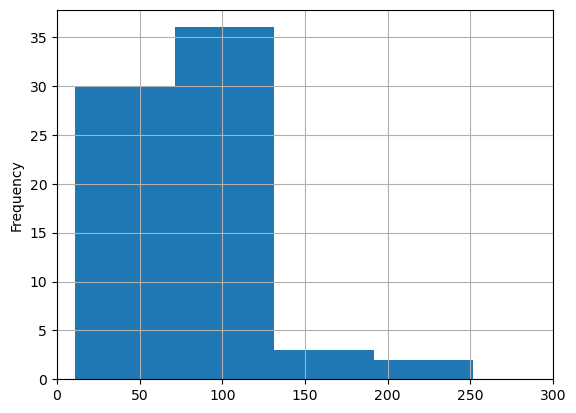

In [15]:

tenure_counts.plot(kind='hist', grid=True, xlim=(0,300))
plt.show()

<font color='red'>TODO :</font>

tenure is having 73 unique values. 
> majority values ranging from 0-250
> 
> How to proceed ? Change it to categorical value. example <50 = 1 | <100 = 2 ...


In [16]:
# SeniorCitizen

data['SeniorCitizen'].value_counts()

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

<hr/>

In [17]:
data.describe(include='O').T

,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


All values except customerID is categorical<hr>

In [18]:
# null check
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

No features are null<hr>

## EDA

In [19]:
# univariant
data.select_dtypes(include=['int','float']).columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [20]:
SeniorCitizen_counts = data['SeniorCitizen'].value_counts()

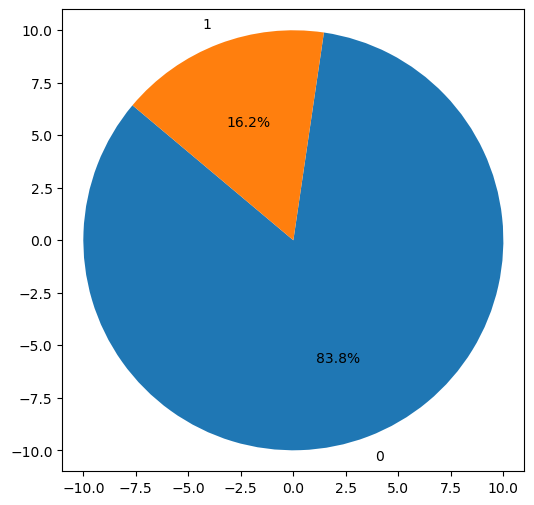

In [21]:
SeniorCitizen_counts = data['SeniorCitizen'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(SeniorCitizen_counts, labels=SeniorCitizen_counts.index, frame=True,startangle=140, autopct='%1.1f%%', radius=10 )
plt.show()

In [22]:
import dtale

In [23]:
dtale.show(data)

<hr>

## Outliers

In [24]:
num_cols = data.select_dtypes(include=['int','float']).columns

In [25]:
%run D:\DataMites\MyLibrary\keerthi_handle_outlier_class.ipynb

In [26]:
ho = HandleOutliers()

In [27]:
num_cols

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

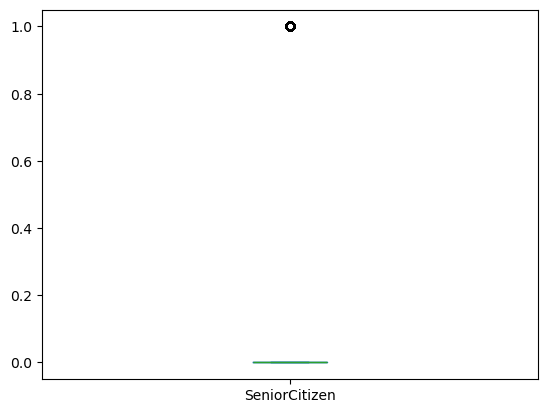

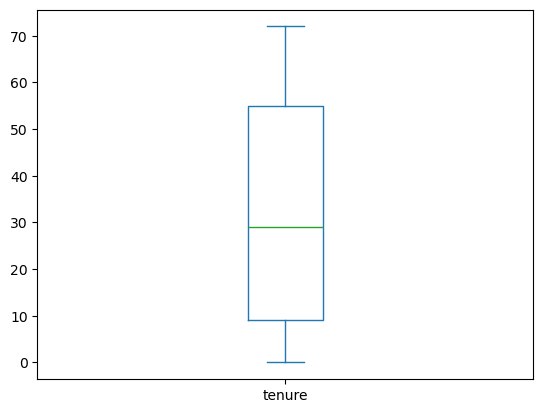

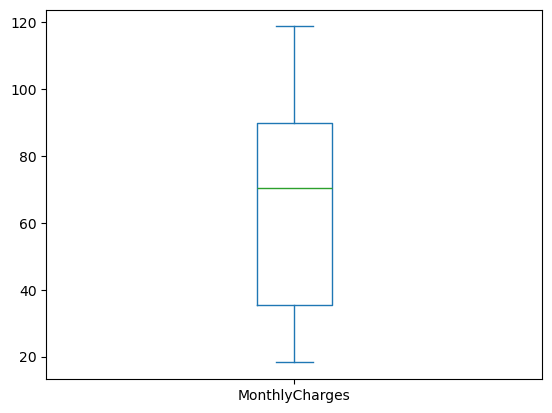

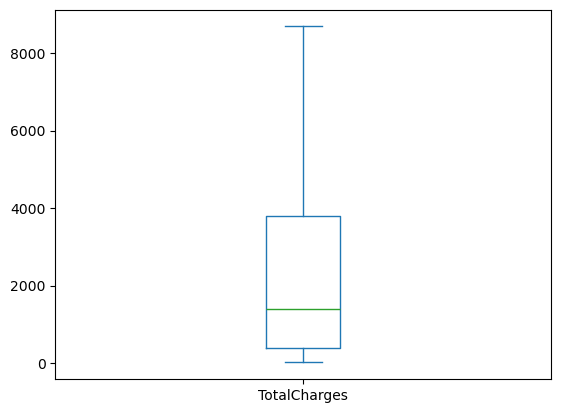

In [28]:
for ele in num_cols:
    data[ele].plot(kind='box')
    plt.show()

No Outliers<hr>

### col rename

In [29]:
col_names = data.columns

In [30]:
def add_underscore_before_caps(s):
    return re.sub(r'([A-Z])', r'_\1', s)

# () -> Capture and group 
# \1 -> use group 1

In [31]:
import string

In [32]:
for name in col_names:
    print(name)
    data.rename(columns={name:add_underscore_before_caps(name)}, inplace=True)
    

customerID
gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges
Churn


In [33]:
data.columns = data.columns.str.lower()

In [34]:
data.columns

Index(['customer_i_d', 'gender', '_senior_citizen', '_partner', '_dependents',
       'tenure', '_phone_service', '_multiple_lines', '_internet_service',
       '_online_security', '_online_backup', '_device_protection',
       '_tech_support', '_streaming_t_v', '_streaming_movies', '_contract',
       '_paperless_billing', '_payment_method', '_monthly_charges',
       '_total_charges', '_churn'],
      dtype='object')

In [35]:
data.columns = data.columns.map(lambda x: re.sub(r'^_', '', x))

In [36]:
data.columns


Index(['customer_i_d', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn'],
      dtype='object')

<hr>

### Co-relation

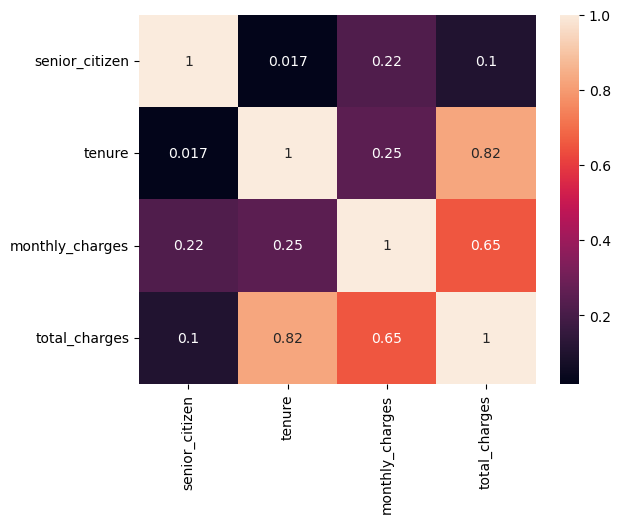

In [37]:
sns.heatmap(data.select_dtypes(exclude='O').corr(), annot=True)
plt.show()

No high co-relation <hr>

## Preprocessing
* drop cols - customerID
* encoding categorical
* Normalise / standardise

In [38]:
data.drop(columns=['customer_i_d'], axis=1, )

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [39]:
# Encoding
cat_cols = data.select_dtypes(include='O').columns
num_cols = data.select_dtypes(exclude='O').columns
print(cat_cols)
print(num_cols)

Index(['customer_i_d', 'gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies', 'contract', 'paperless_billing', 'payment_method',
       'churn'],
      dtype='object')
Index(['senior_citizen', 'tenure', 'monthly_charges', 'total_charges'], dtype='object')


In [40]:
for c in cat_cols:
    print(c ," -  ",data[c].unique())

customer_i_d  -   ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender  -   ['Female' 'Male']
partner  -   ['Yes' 'No']
dependents  -   ['No' 'Yes']
phone_service  -   ['No' 'Yes']
multiple_lines  -   ['No phone service' 'No' 'Yes']
internet_service  -   ['DSL' 'Fiber optic' 'No']
online_security  -   ['No' 'Yes' 'No internet service']
online_backup  -   ['Yes' 'No' 'No internet service']
device_protection  -   ['No' 'Yes' 'No internet service']
tech_support  -   ['No' 'Yes' 'No internet service']
streaming_t_v  -   ['No' 'Yes' 'No internet service']
streaming_movies  -   ['No' 'Yes' 'No internet service']
contract  -   ['Month-to-month' 'One year' 'Two year']
paperless_billing  -   ['Yes' 'No']
payment_method  -   ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
churn  -   ['No' 'Yes']


multiple_lines  - 'No phone service' => No

'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies'

In [41]:
data['multiple_lines'].replace(to_replace=r'.*phone.*', value='No', regex=True, inplace=True)

In [42]:
replace_internet = ['online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies']

In [43]:
data.loc[:,replace_internet ] = data.loc[:, replace_internet].replace(to_replace='.*internet.*', value='No', regex=True)

In [44]:
for c in cat_cols:
    print(c ," -  ",data[c].unique())

customer_i_d  -   ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender  -   ['Female' 'Male']
partner  -   ['Yes' 'No']
dependents  -   ['No' 'Yes']
phone_service  -   ['No' 'Yes']
multiple_lines  -   ['No' 'Yes']
internet_service  -   ['DSL' 'Fiber optic' 'No']
online_security  -   ['No' 'Yes']
online_backup  -   ['Yes' 'No']
device_protection  -   ['No' 'Yes']
tech_support  -   ['No' 'Yes']
streaming_t_v  -   ['No' 'Yes']
streaming_movies  -   ['No' 'Yes']
contract  -   ['Month-to-month' 'One year' 'Two year']
paperless_billing  -   ['Yes' 'No']
payment_method  -   ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
churn  -   ['No' 'Yes']


Now segregate cols for one-hot encoding, ordinal encoding

In [45]:
data.columns

Index(['customer_i_d', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn'],
      dtype='object')

In [46]:
one_hot_cols = ['gender', 'partner', 'dependents',
       'phone_service', 'multiple_lines','online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v','streaming_movies','paperless_billing', 'churn']
ordinal_col = ['internet_service','contract','payment_method']

In [47]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [48]:
one_hot_encoder = OneHotEncoder( sparse_output=False,feature_name_combiner='concat', dtype='int')

In [49]:
one_hot_encoded = one_hot_encoder.fit_transform(data[one_hot_cols])

In [50]:
one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols))

In [51]:
one_hot_encoded

,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,phone_service_No,phone_service_Yes,multiple_lines_No,multiple_lines_Yes,...,tech_support_No,tech_support_Yes,streaming_t_v_No,streaming_t_v_Yes,streaming_movies_No,streaming_movies_Yes,paperless_billing_No,paperless_billing_Yes,churn_No,churn_Yes
0,1,0,0,1,1,0,1,0,1,0,...,1,0,1,0,1,0,0,1,1,0
1,0,1,1,0,1,0,0,1,1,0,...,1,0,1,0,1,0,1,0,1,0
2,0,1,1,0,1,0,0,1,1,0,...,1,0,1,0,1,0,0,1,0,1
3,0,1,1,0,1,0,1,0,1,0,...,0,1,1,0,1,0,1,0,1,0
4,1,0,1,0,1,0,0,1,1,0,...,1,0,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,0,1,0,1,0,1,0,1,...,0,1,0,1,0,1,0,1,1,0
7039,1,0,0,1,0,1,0,1,0,1,...,1,0,0,1,0,1,0,1,1,0
7040,1,0,0,1,0,1,1,0,1,0,...,1,0,1,0,1,0,0,1,1,0
7041,0,1,0,1,1,0,0,1,0,1,...,1,0,1,0,1,0,0,1,0,1


In [52]:
#ordinal_col = ['internet_service','contract','payment_method']
# internet_service  -   ['DSL' 'Fiber optic' 'No']
# contract  -   ['Month-to-month' 'One year' 'Two year']
# payment_method  -   ['Electronic check' 'Mailed check' 'Bank transfer (automatic)', 'Credit card (automatic)']

from sklearn.preprocessing import OrdinalEncoder

In [53]:
ordinal_encoder = OrdinalEncoder(dtype='int', categories=[['No','DSL', 'Fiber optic'],['Month-to-month', 'One year', 'Two year'],
                                                          ['Mailed check', 'Electronic check', 'Bank transfer (automatic)',
                                                           'Credit card (automatic)' ]])

In [54]:
ordinal_encoded = ordinal_encoder.fit_transform(data[ordinal_col])

In [55]:
ordinal_encoded_data = pd.DataFrame(ordinal_encoded, columns=ordinal_encoder.get_feature_names_out(ordinal_col))

In [56]:
ordinal_encoded_data

,internet_service,contract,payment_method
0,1,0,1
1,1,1,0
2,1,0,0
3,1,1,2
4,2,0,1
...,...,...,...
7038,1,1,0
7039,2,1,3
7040,1,0,1
7041,2,0,0


In [57]:
# Scale down data
from sklearn.preprocessing import StandardScaler

In [58]:
scaler = StandardScaler()

In [59]:
scale_cols = ['monthly_charges', 'total_charges', 'tenure']
scaled_data = scaler.fit_transform(data[scale_cols])
scaled_data = pd.DataFrame(scaled_data, columns=scale_cols)
scaled_data

,monthly_charges,total_charges,tenure
0,-1.160323,-0.994971,-1.277445
1,-0.259629,-0.173876,0.066327
2,-0.362660,-0.960399,-1.236724
3,-0.746535,-0.195400,0.514251
4,0.197365,-0.941193,-1.236724
...,...,...,...
7038,0.665992,-0.129281,-0.340876
7039,1.277533,2.242808,1.613701
7040,-1.168632,-0.855182,-0.870241
7041,0.320338,-0.872777,-1.155283


In [60]:
data

,customer_i_d,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_t_v,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [61]:
data2 = pd.concat([scaled_data, ordinal_encoded_data, one_hot_encoded], axis=1)

In [62]:
data2

,monthly_charges,total_charges,tenure,internet_service,contract,payment_method,gender_Female,gender_Male,partner_No,partner_Yes,...,tech_support_No,tech_support_Yes,streaming_t_v_No,streaming_t_v_Yes,streaming_movies_No,streaming_movies_Yes,paperless_billing_No,paperless_billing_Yes,churn_No,churn_Yes
0,-1.160323,-0.994971,-1.277445,1,0,1,1,0,0,1,...,1,0,1,0,1,0,0,1,1,0
1,-0.259629,-0.173876,0.066327,1,1,0,0,1,1,0,...,1,0,1,0,1,0,1,0,1,0
2,-0.362660,-0.960399,-1.236724,1,0,0,0,1,1,0,...,1,0,1,0,1,0,0,1,0,1
3,-0.746535,-0.195400,0.514251,1,1,2,0,1,1,0,...,0,1,1,0,1,0,1,0,1,0
4,0.197365,-0.941193,-1.236724,2,0,1,1,0,1,0,...,1,0,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.665992,-0.129281,-0.340876,1,1,0,0,1,0,1,...,0,1,0,1,0,1,0,1,1,0
7039,1.277533,2.242808,1.613701,2,1,3,1,0,0,1,...,1,0,0,1,0,1,0,1,1,0
7040,-1.168632,-0.855182,-0.870241,1,0,1,1,0,0,1,...,1,0,1,0,1,0,0,1,1,0
7041,0.320338,-0.872777,-1.155283,2,0,0,0,1,0,1,...,1,0,1,0,1,0,0,1,0,1


Data2 => Scaled, one-hot, ordinal encoded<hr>

## Train Test split

In [63]:
data2.columns

Index(['monthly_charges', 'total_charges', 'tenure', 'internet_service',
       'contract', 'payment_method', 'gender_Female', 'gender_Male',
       'partner_No', 'partner_Yes', 'dependents_No', 'dependents_Yes',
       'phone_service_No', 'phone_service_Yes', 'multiple_lines_No',
       'multiple_lines_Yes', 'online_security_No', 'online_security_Yes',
       'online_backup_No', 'online_backup_Yes', 'device_protection_No',
       'device_protection_Yes', 'tech_support_No', 'tech_support_Yes',
       'streaming_t_v_No', 'streaming_t_v_Yes', 'streaming_movies_No',
       'streaming_movies_Yes', 'paperless_billing_No', 'paperless_billing_Yes',
       'churn_No', 'churn_Yes'],
      dtype='object')

In [65]:
data2.drop('churn_No',axis=1, inplace=True)

In [66]:
y = data2.churn_Yes
x = data2.iloc[:,:-1]
x.columns

Index(['monthly_charges', 'total_charges', 'tenure', 'internet_service',
       'contract', 'payment_method', 'gender_Female', 'gender_Male',
       'partner_No', 'partner_Yes', 'dependents_No', 'dependents_Yes',
       'phone_service_No', 'phone_service_Yes', 'multiple_lines_No',
       'multiple_lines_Yes', 'online_security_No', 'online_security_Yes',
       'online_backup_No', 'online_backup_Yes', 'device_protection_No',
       'device_protection_Yes', 'tech_support_No', 'tech_support_Yes',
       'streaming_t_v_No', 'streaming_t_v_Yes', 'streaming_movies_No',
       'streaming_movies_Yes', 'paperless_billing_No',
       'paperless_billing_Yes'],
      dtype='object')

In [67]:
from sklearn.model_selection import train_test_split

x_train,x_test, y_train, y_test = train_test_split(x,y)

### Check for Balancing

In [68]:
data2.churn_Yes.value_counts()

churn_Yes
0    5174
1    1869
Name: count, dtype: int64

In [69]:
y_train.value_counts()

churn_Yes
0    3914
1    1368
Name: count, dtype: int64

Data is in-balanced. Balanceing using SMOTE

In [71]:
smote_enn = SMOTEENN()

x_train, y_train = smote_enn.fit_resample(x_train,y_train)

y_train.value_counts()

churn_Yes
1    2734
0    2186
Name: count, dtype: int64

## Model Building
supervised-classification nature
1. logistic regression
2. SVM - SVC
3. PCA
4. KNN 
5. RF
6. DT
7. GB, XGB

Applying all algorithms tofind best classifier. and then apply hyper-parameter tuning, cv and boosting

In [72]:
all_model_report = pd.DataFrame(columns=['model', 'train_accuracy', 'test_accuracy', 'f1', 'auc'])

#### Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(random_state=2,fit_intercept=True)

model_lr.fit(x_train, y_train)

LogisticRegression(random_state=2)

In [74]:
lr_y_train_hat = model_lr.predict(x_train)

In [76]:
print(f1_score(y_train, lr_y_train_hat))

print(accuracy_score(y_train, lr_y_train_hat))

print(classification_report(y_train, lr_y_train_hat))
print(roc_auc_score(y_train, lr_y_train_hat))

0.9399344739716053
0.9329268292682927
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2186
           1       0.94      0.94      0.94      2734

    accuracy                           0.93      4920
   macro avg       0.93      0.93      0.93      4920
weighted avg       0.93      0.93      0.93      4920

0.9314882697701875


In [77]:
lr_y_test_hat = model_lr.predict(x_test)

In [78]:
print(f1_score(y_test, lr_y_test_hat))
print(accuracy_score(y_test, lr_y_test_hat))
print(classification_report(y_test, lr_y_test_hat))
print(roc_auc_score(y_test, lr_y_test_hat))

0.6493927125506073
0.7541169789892107
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1260
           1       0.55      0.80      0.65       501

    accuracy                           0.75      1761
   macro avg       0.72      0.77      0.73      1761
weighted avg       0.80      0.75      0.76      1761

0.7680567436555461


In [79]:
all_model_report.loc[len(all_model_report)] = ['Log', 100,100, 100, 100]

train accuracy = 100% <br>
test accuracy = 100%
<hr>

#### SVC

In [80]:
from sklearn.svm import SVC

In [81]:
model_svc = SVC(random_state=2)

In [82]:
model_svc.fit(x_train, y_train)

SVC(random_state=2)

In [83]:
svc_y_train_hat = model_svc.predict(x_train)

In [84]:
print(f1_score(y_train, svc_y_train_hat))
print(accuracy_score(y_train, svc_y_train_hat))
print(classification_report(y_train, svc_y_train_hat))

0.9608411892675852
0.9560975609756097
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2186
           1       0.95      0.97      0.96      2734

    accuracy                           0.96      4920
   macro avg       0.96      0.95      0.96      4920
weighted avg       0.96      0.96      0.96      4920



In [85]:
svc_y_test_hat = model_svc.predict(x_test)

In [86]:
print(f1_score(y_test, svc_y_test_hat))
print(accuracy_score(y_test, svc_y_test_hat))
print(classification_report(y_test, svc_y_test_hat))
print(roc_auc_score(y_test, svc_y_test_hat))

0.6422893481717011
0.7444633730834753
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1260
           1       0.53      0.81      0.64       501

    accuracy                           0.74      1761
   macro avg       0.72      0.76      0.72      1761
weighted avg       0.80      0.74      0.76      1761

0.7631142476950861


In [87]:
all_model_report.loc[len(all_model_report)] = ['SVC', 82, 76, 64, 77 ]

train accuracy = 82%<br>
test accuracy = 76%
<hr>

#### KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier

In [89]:
model_knn = KNeighborsClassifier()

In [90]:
model_knn.fit(x_train,y_train)

KNeighborsClassifier()

In [91]:
knn_y_train_hat = model_knn.predict(x_train)

In [92]:
print(f1_score(y_train, knn_y_train_hat))
print(accuracy_score(y_train, knn_y_train_hat))
print(classification_report(y_train, knn_y_train_hat))

0.9833994947672321
0.9813008130081301
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2186
           1       0.97      1.00      0.98      2734

    accuracy                           0.98      4920
   macro avg       0.98      0.98      0.98      4920
weighted avg       0.98      0.98      0.98      4920



In [93]:
knn_y_test_hat = model_knn.predict(x_test)

In [94]:
print(f1_score(y_test, knn_y_test_hat))
print(accuracy_score(y_test, knn_y_test_hat))
print(classification_report(y_test, knn_y_test_hat))
print(roc_auc_score(y_test, knn_y_test_hat))

0.6150341685649203
0.7120954003407155
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      1260
           1       0.50      0.81      0.62       501

    accuracy                           0.71      1761
   macro avg       0.70      0.74      0.69      1761
weighted avg       0.78      0.71      0.73      1761

0.741096378671229


In [95]:
all_model_report.loc[len(all_model_report)] = ['KNN', 87, 73, 56, 70 ]

train accuracy = 87%<br>
test accuracy = 73%
<hr>

#### Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
model_rf = RandomForestClassifier(random_state=2,)

In [98]:
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=2)

In [99]:
rf_y_train_hat = model_rf.predict(x_train)
rf_y_test_hat = model_rf.predict(x_test)

In [100]:
print(f1_score(y_train, rf_y_train_hat))
print(accuracy_score(y_train, rf_y_train_hat))
print(classification_report(y_train, rf_y_train_hat))

1.0
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2186
           1       1.00      1.00      1.00      2734

    accuracy                           1.00      4920
   macro avg       1.00      1.00      1.00      4920
weighted avg       1.00      1.00      1.00      4920



In [101]:
print(f1_score(y_test, rf_y_test_hat))
print(accuracy_score(y_test, rf_y_test_hat))
print(classification_report(y_test, rf_y_test_hat))
print(roc_auc_score(y_test, rf_y_test_hat))

0.6267432321575062
0.7416240772288473
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1260
           1       0.53      0.76      0.63       501

    accuracy                           0.74      1761
   macro avg       0.71      0.75      0.71      1761
weighted avg       0.79      0.74      0.75      1761

0.7479041916167666


In [102]:
all_model_report.loc[len(all_model_report)] = ['RF', 100, 78, 62, 74 ]

train accuracy = 100%<br>
test accuracy = 78%
<hr>

#### Decission Tree

In [103]:
from sklearn.tree import DecisionTreeClassifier

In [104]:
model_dt = DecisionTreeClassifier(random_state=2)

In [105]:
model_dt.fit(x_train,y_train)

DecisionTreeClassifier(random_state=2)

In [106]:
dt_y_train_hat = model_dt.predict(x_train)
dt_y_test_hat = model_dt.predict(x_test)


In [107]:
print(f1_score(y_train, dt_y_train_hat))
print(accuracy_score(y_train, dt_y_train_hat))
print(classification_report(y_train, dt_y_train_hat))

1.0
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2186
           1       1.00      1.00      1.00      2734

    accuracy                           1.00      4920
   macro avg       1.00      1.00      1.00      4920
weighted avg       1.00      1.00      1.00      4920



In [108]:
print(f1_score(y_test, dt_y_test_hat))
print(accuracy_score(y_test, dt_y_test_hat))
print(classification_report(y_test, dt_y_test_hat))
print(roc_auc_score(y_test, dt_y_test_hat))

0.5935162094763092
0.7223168654173765
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      1260
           1       0.51      0.71      0.59       501

    accuracy                           0.72      1761
   macro avg       0.69      0.72      0.69      1761
weighted avg       0.76      0.72      0.73      1761

0.7193826632449386


In [109]:
all_model_report.loc[len(all_model_report)] = ['DT', 100, 74, 54, 68 ]

train accuracy = 100%<br>
test accuracy = 74%
<hr>

#### Gradient Boosting

In [110]:
from sklearn.ensemble import GradientBoostingClassifier

In [111]:
model_gb = GradientBoostingClassifier(random_state=2)

In [112]:
model_gb.fit(x_train, y_train)

GradientBoostingClassifier(random_state=2)

In [113]:
gb_y_train_hat = model_gb.predict(x_train)
gb_y_test_hat = model_gb.predict(x_test)

In [114]:
print(f1_score(y_train, gb_y_train_hat))
print(accuracy_score(y_train, gb_y_train_hat))
print(classification_report(y_train, gb_y_train_hat))

0.9560180995475113
0.9506097560975609
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2186
           1       0.95      0.97      0.96      2734

    accuracy                           0.95      4920
   macro avg       0.95      0.95      0.95      4920
weighted avg       0.95      0.95      0.95      4920



In [115]:
print(f1_score(y_test, gb_y_test_hat))
print(accuracy_score(y_test, gb_y_test_hat))
print(classification_report(y_test, gb_y_test_hat))
print(roc_auc_score(y_test, gb_y_test_hat))

0.6465927099841522
0.7467348097671778
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1260
           1       0.54      0.81      0.65       501

    accuracy                           0.75      1761
   macro avg       0.72      0.77      0.72      1761
weighted avg       0.80      0.75      0.76      1761

0.7671062636631498


In [116]:
all_model_report.loc[len(all_model_report)] = ['GB', 82, 77, 65, 78 ]

train accuracy = 82% <br>
test accuracy = 77%
<hr>

#### XGB

XGBoost comes with its own class for storing datasets called DMatrix. It is a highly optimized class for memory and speed. That's why converting datasets into this format is a requirement for the native XGBoost API:

There are 2 version of XGB. 
* Native - requires data to be in DMatrix
* Sklearn



In [117]:
import xgboost as xgb

In [118]:
# d_train = xgb.DMatrix(x_train, y_train, enable_categorical=True)
# d_test = xgb.DMatrix(x_test, y_test, enable_categorical=True)

In [119]:
model_xgb = xgb.XGBClassifier()

In [120]:
model_xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [121]:
xgb_y_train_hat = model_xgb.predict(x_train)

In [125]:
xgb_y_test_hat = model_xgb.predict(x_test)

In [152]:
print(f1_score(y_train, xgb_y_train_hat))
print(accuracy_score(y_train, xgb_y_train_hat))
print(classification_report(y_train, xgb_y_train_hat))

1.0
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2186
           1       1.00      1.00      1.00      2734

    accuracy                           1.00      4920
   macro avg       1.00      1.00      1.00      4920
weighted avg       1.00      1.00      1.00      4920



In [153]:
print(f1_score(y_test, xgb_y_test_hat))
print(accuracy_score(y_test, xgb_y_test_hat))
print(classification_report(y_test, xgb_y_test_hat))
print(roc_auc_score(y_test, xgb_y_test_hat))

0.6326530612244898
0.7546848381601363
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1260
           1       0.55      0.74      0.63       501

    accuracy                           0.75      1761
   macro avg       0.72      0.75      0.72      1761
weighted avg       0.79      0.75      0.76      1761

0.7510193897918449


train accuracy : 95%<br>
test accuracy : 77<hr>

In [154]:
all_model_report = pd.DataFrame(columns=['model', 'train_accuracy', 'test_accuracy', 'f1', 'auc'])

In [155]:
all_model_report.loc[0] = ['XGB', 95, 77, 58, 72 ]

In [156]:
all_model_report

,model,train_accuracy,test_accuracy,f1,auc
0,XGB,95,77,58,72


In [157]:
all_model_report['accuracy_diff'] = np.absolute(all_model_report['train_accuracy'] - all_model_report['test_accuracy'])

In [158]:
all_model_report

,model,train_accuracy,test_accuracy,f1,auc,accuracy_diff
0,XGB,95,77,58,72,18


* LogReg has best bias-variance trade-off
* RF has high accuracy and overfitting
using hyper-parameter on RF

### hyper-parameter - RF

In [159]:
from sklearn.model_selection import RandomizedSearchCV

In [160]:
params_rf = {'n_estimators':[10,20,30,70],
            'criterion':["gini", "entropy", "log_loss"],
            'max_depth':[5,10,15,20],
            'min_samples_split':[2,5,8,12,15],
            'min_samples_leaf': np.linspace(1,20, 4, dtype='int'),
            'max_leaf_nodes': np.linspace(10, 80, 10, dtype='int'),
            }

In [161]:
rcv_rf = RandomizedSearchCV(RandomForestClassifier(random_state=2), param_distributions=params_rf, scoring='accuracy')

In [162]:
rcv_rf.fit(x_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=2),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [5, 10, 15, 20],
                                        'max_leaf_nodes': array([10, 17, 25, 33, 41, 48, 56, 64, 72, 80]),
                                        'min_samples_leaf': array([ 1,  7, 13, 20]),
                                        'min_samples_split': [2, 5, 8, 12, 15],
                                        'n_estimators': [10, 20, 30, 70]},
                   scoring='accuracy')

In [163]:
rcv_rf.best_estimator_

RandomForestClassifier(criterion='log_loss', max_depth=10, max_leaf_nodes=56,
                       n_estimators=70, random_state=2)

In [164]:
rcv_rf.best_params_

{'n_estimators': 70,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 56,
 'max_depth': 10,
 'criterion': 'log_loss'}

In [165]:
rcv_rf.best_score_

0.9310975609756097

In [166]:
rf_model = rcv_rf.best_estimator_

In [167]:
rf_model.fit(x_train, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=10, max_leaf_nodes=56,
                       n_estimators=70, random_state=2)

In [168]:
y_train_hat = rf_model.predict(x_train)

In [169]:
print(f1_score(y_train, y_train_hat))
print(accuracy_score(y_train, y_train_hat))
print(classification_report(y_train, y_train_hat))

0.9515053181900126
0.9453252032520325
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      2186
           1       0.94      0.97      0.95      2734

    accuracy                           0.95      4920
   macro avg       0.95      0.94      0.94      4920
weighted avg       0.95      0.95      0.95      4920



In [170]:
y_test_hat = rf_model.predict(x_test)

In [171]:
print(f1_score(y_test, y_test_hat))
print(accuracy_score(y_test, y_test_hat))
print(classification_report(y_test, y_test_hat))
print(roc_auc_score(y_test, rf_y_test_hat))

0.631578947368421
0.7296990346394094
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1260
           1       0.52      0.81      0.63       501

    accuracy                           0.73      1761
   macro avg       0.71      0.76      0.71      1761
weighted avg       0.79      0.73      0.74      1761

0.7479041916167666


## Modeling with pipeline

In [172]:
from sklearn.pipeline import Pipeline

In [173]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [174]:
models = [
    ("Logistic Regression", LogisticRegression(random_state=42),  {'model__C': [0.1, 1, 10],'model__penalty': ['l1', 'l2']}),
    ("SVC", SVC(random_state=42), {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}),
    ("KNN", KNeighborsClassifier(), {'model__n_neighbors': [3, 5, 7],'model__weights': ['uniform', 'distance']}),
    ("Random Forest", RandomForestClassifier(random_state=42), {'model__n_estimators': [50, 100, 200], 'model__max_depth': [None, 10, 20]}),
    ("Decission Tree", DecisionTreeClassifier(random_state=42), {'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5, 10]}),
    ("GB", GradientBoostingClassifier(random_state=42), {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.05, 0.1, 0.5]}),
    ("XGB", xgb.XGBClassifier(), {'model__n_estimators': [50, 100, 200],'model__learning_rate': [0.05, 0.1, 0.5]})]

In [175]:
from sklearn.model_selection import GridSearchCV

In [176]:
model_score = []
best_accuracy = 0
best_model = None

In [177]:
for name, model, params in models:
    print(name, model, params)
    pipeline = Pipeline([('model', model)])

    if params:
        gcv = GridSearchCV(pipeline, param_grid=params,scoring='accuracy', cv=3, return_train_score=True)
        gcv.fit(x_train, y_train)
        pipeline = gcv.best_estimator_

    pipeline.fit(x_train, y_train)
    y_train_hat = pipeline.predict(x_train)
    y_test_hat = pipeline.predict(x_test)
    
    y_train_accuracy = accuracy_score(y_train, y_train_hat)
    y_test_accuracy = accuracy_score(y_test, y_test_hat)
    f1 = f1_score(y_test, y_test_hat)
    roc_score = roc_auc_score(y_test, y_test_hat)
    accuracy_diff = np.absolute(y_train_accuracy - y_test_accuracy)
    scores = { "model" : model,
                        "train accuracy":y_train_accuracy,
                        "test accuracy":y_test_accuracy,
                        "f1 score": f1,
                        "roc_auc curve": roc_score,
                        "accuracy_diff": accuracy_diff}
    
    model_score.append(scores)
    print(scores)

    if y_test_accuracy > best_accuracy:
        best_accuracy = y_test_accuracy
        best_model = pipeline
    

Logistic Regression LogisticRegression(random_state=42) {'model__C': [0.1, 1, 10], 'model__penalty': ['l1', 'l2']}
{'model': LogisticRegression(random_state=42), 'train accuracy': 0.9373983739837398, 'test accuracy': 0.7575241340147644, 'f1 score': 0.6473988439306358, 'roc_auc curve': 0.7650270886797834, 'accuracy_diff': 0.17987423996897545}
SVC SVC(random_state=42) {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}
{'model': SVC(random_state=42), 'train accuracy': 0.9823170731707317, 'test accuracy': 0.7382169222032936, 'f1 score': 0.6230580539656582, 'roc_auc curve': 0.7449220606406235, 'accuracy_diff': 0.2441001509674381}
KNN KNeighborsClassifier() {'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance']}
{'model': KNeighborsClassifier(), 'train accuracy': 1.0, 'test accuracy': 0.7115275411697899, 'f1 score': 0.6012558869701727, 'roc_auc curve': 0.727473624180211, 'accuracy_diff': 0.2884724588302101}
Random Forest RandomForestClassifier(random_state=42)

In [178]:
pd.DataFrame(model_score)

,model,train accuracy,test accuracy,f1 score,roc_auc curve,accuracy_diff
0,LogisticRegression(random_state=42),0.937398,0.757524,0.647399,0.765027,0.179874
1,SVC(random_state=42),0.982317,0.738217,0.623058,0.744922,0.244100
2,KNeighborsClassifier(),1.000000,0.711528,0.601256,0.727474,0.288472
3,RandomForestClassifier(random_state=42),1.000000,0.742192,0.627869,0.748902,0.257808
4,DecisionTreeClassifier(random_state=42),1.000000,0.721181,0.593879,0.719791,0.278819
5,GradientBoostingClassifier(random_state=42),0.988821,0.755821,0.642263,0.760230,0.233001
6,"XGBClassifier(base_score=None, booster=None, c...",1.000000,0.751846,0.631224,0.750238,0.248154


In [179]:
best_accuracy 

0.7575241340147644

In [180]:
best_model 

Pipeline(steps=[('model', LogisticRegression(C=10, random_state=42))])